# Concepts

GARCH stands for "Generalized AutoRegressive Conditional Heteroskedasticity", and it is a popular approach to model volatility. Its based on https://campus.datacamp.com/courses/garch-models-in-python/

## What is volatility ?


In finance, volatility is a statistical measure of the dispersion of asset returns over time. It is often computed as the standard deviation or variance of price returns. We will use the term "volatility" to describe standard deviation or variance interchangeably. Volatility describes uncertainties surrounding the potential price movement of financial assets. 

It is an essential concept widely used in risk management, portfolio optimization, and more. And it has been one of the most active areas of research in empirical finance and time series analysis. In general, the higher the volatility, the riskier a financial asset.


### How to compute volatility?

We can compute the volatility as the standard deviation of price returns following three easy steps. 

* Step 1 is to calculate the returns as percentage price changes.
* Step 2 is to calculate the sample mean return of a chosen n-period.
* Step 3 is to derive the sample standard deviation. 

Also recall standard deviation is the square root of variance.

### Volatility conversion

Assume we measure volatility as the standard deviation of returns, then monthly volatility can be obtained by multiplying daily volatility by the square root of 21, which is the average number or trading days in a month. 

Similarly, annual volatility can be obtained by multiplying daily volatility by the square root of 252, which is the average number or trading days in a year.

### The Challenge

A common assumption in time series modeling is that volatility remains constant over time. However, heteroskedasticity, literally means "different dispersion" in ancient Greek, is frequently observed in financial return data. Volatility tends to increase or decrease systematically over time.

## ARCH & GARCH

Before GARCH, first came the ARCH models. ARCH stands for "Auto-Regressive Conditional Heteroskedasticity", and was developed by American economist Robert F. Engle in 1982. Here "conditional heteroscedasticity" means the data has time-dependent varying characteristic and unpredictable. Due to his contribution, Engle won the Nobel prize in economics in 2003.

Based on ARCH, GARCH models were developed by Danish economist Tim Bollerslev in 1986. The "G" in GARCH stands for "Generalized". Fun fact: Bollerslev wrote about the GARCH models in his Ph.D thesis, under the supervision of Engle, who was the inventor of ARCH models.

### White Noise

A time series is white noise if the variables are independent and identically distributed with a mean of zero. A residual is the difference between the observed value of a variable at time t and its predicted value based on information available prior to time t. 

If the prediction model is working properly, successive residuals are uncorrelated with each other, that is, they constitute a white noise time series. 

In other words, the model has taken care of all the predictable components of a time series, left only the unpredictable white noise part.

### GARCH(1,1) parameter constraints

To make a GARCH(1,1) process realistic, there are two conditions. First, it requires all the parameters, omega, alpha, and beta, to be non-negative. This ensures the variance can't be negative. Second, alpha plus beta should be less than one, which ensures the model estimated variance is always "mean-reverting" to the long-run variance. The long-run variance equals to omega divided by one minus alpha minus beta.

### GARCH(1,1) parameter dynamics

The rule of thumb regarding model parameter is: the larger the alpha, the bigger the immediate impact of the shocks. Here the shocks are expressed as residuals, or prediction errors. If we keep the alpha fixed, the larger the beta, the longer the duration of the impact, that is, high or low volatility periods tend to persist.

## Dataset & Libs

In [42]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as tsa
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
import math
import datetime as dt
import statsmodels.stats.api as sms

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
from arch import arch_model
from arch.univariate import ARX
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [13]:
def read_datasets():
    df = create_index_datatime(pd.read_csv('itausa.csv',';'))
    df = df.interpolate()                                                 
    return df

def create_index_datatime(df):
    
    format = '%Y-%m-%d'
    
    df['data'] = pd.to_datetime(df['data'],format=format).dt.date
    df['anoMes'] = pd.to_datetime(df['data'],format=format).dt.strftime('%Y-%m')
    
    df = df.set_index('data')
    
    return df

## Stats Func Test

In [22]:
def adf_test(dataset, log_test = False):
    ds = dataset
    
    if log_test:
        ds = np.log(ds)
        ds.dropna(inplace=True)
    
    alpha = 0.05
    
    result = tsa.adfuller(ds)
    print('Augmented Dickey-Fuller Test')
    print('test statistic: %.10f' % result[0])
    print('p-value: %.10f' % result[1])
    print('critical values')
    
    for key, value in result[4].items():
        print('\t%s: %.10f' % (key, value))
        
    if result[1] < alpha:  #valor de alpha é 0.05 ou 5 %
        print("Rejeitamos a Hipotese Nula")
    else:
        print("Aceitamos a Hipotese Nula")

In [23]:
def normal_distribution_test(residual):
    print("\n normal_distribution_test \n ")
    print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
    print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
    print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])
    return

In [24]:
def heteroscedasticity_test(results):
    print("\n heteroscedasticity_test \n ")
    print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(results.resid, results.model.exog)[1])
    #print('p value of White test is: ', sms.het_white(results.resid, results.model.exog)[1])
    return

In [25]:
def varianceInflationFactor_test(df, target,exog):

    features = "+".join(df[exog].columns)
    print(features)
    
    t_target = target.join(" ~")
    
    y, X = dmatrices(t_target + features, df, return_type='dataframe')
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = [target]+exog
    
    return vif

In [19]:
def print_corr(df,titulo):

    mask = np.triu(np.ones_like(df, dtype=bool))

    f, ax = plt.subplots(1,figsize=(10, 8))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(df, cmap=cmap, vmax=.9, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax.set(Title=titulo)

    plt.show()

## Model Functions

In [7]:
def get_model_metrics(actual, forecast):
    
    rmse = np.sqrt(mean_squared_error(actual,forecast))
                
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
                
    num = 0
    den = actual.sum()
    for i in range(len(actual)):
        num = num + abs(actual[i]-forecast[i])
    wmape = 1 - num.sum()/den
    
    return rmse, mape, wmape

    
    # 1 - quando usamos todos os dados para ajustar o modelo, a estimativa do modelo
    #tem viés de lookback. Na realidade, não sabemos o futuro, os dados da serie temporal usados
    # para o ajuste do modelo e a previsão não devem se sobrepor.
    
    #2 - Esta abordagem esta menos sujeita a overfitting (sobreajuste). Uma suposição de modelagem
    # de series temporais é que os parametros do modelo são estaveis ao longo do tempo.
    #Mas isso não é verdade em um ambiente de mercado turbulento.
    
    #3 - Pode adaptar melhor a previsão a possiveis mudanças. Ao incorporar continuamente
    # novas observações ao ajuste e preivsão do modelo, estamos mais abertos as condições
    # do mercado como noticias, ciclos economicos etc.


In [156]:
def expanding_rw_forecast(model, df, start_loc,end_loc,n):
    forecasts = {}

    for i in range(n):
        # Specify fixed rolling window size for model fitting
        v_result = model.fit(first_obs = start_loc, 
                                 last_obs = i + end_loc, update_freq = 30)
        
        # Conduct 1-period variance forecast and save the result
        temp_result = v_result.forecast(horizon = 1).variance
        print("\n\n values - >", temp_result.values[-1, :])
        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast
    
    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    
    # Plot the forecast variance
    f, axes = plt.subplots(1, figsize=(15,5))
    plt.plot(forecast_var, color = 'red')
    plt.show()
    f, axes = plt.subplots(1, figsize=(15,5))
    plt.plot(df, color = 'green')
    plt.show()
    
    return forecast_var

In [157]:
def fixed_rw_forecast(model, df, start_loc,end_loc,n):
    # Neste metodo, os pontos de dados antigos são eliminados da amostra
    # simultaneamente para manter um tamanho de janela fixa
    
    forecasts = {}

    for i in range(n):
        # Specify fixed rolling window size for model fitting
        v_result = model.fit(first_obs = i + start_loc, 
                                 last_obs = i + end_loc, update_freq = 30)
        
        # Conduct 1-period variance forecast and save the result
        temp_result = v_result.forecast(horizon = 1).variance
        print("\n\n values - >", temp_result.values[-1, :])
        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast
    
    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    
    # Plot the forecast variance
    f, axes = plt.subplots(1, figsize=(15,5))
    plt.plot(forecast_var, color = 'red')
    plt.show()
    f, axes = plt.subplots(1, figsize=(15,5))
    plt.plot(df, color = 'green')
    plt.show()    
    return forecast_var

In [10]:
def get_arx_model(name,y,exog, lags):
    x=exog
    
    mod = arch_model(y,mean=name, lags=lags,dist="StudentsT")
    res = mod.fit(disp="off")
    print(res.summary())
    
    return mod,res

In [69]:
def get_arch_model(df, p , q, mean, type_model, dist):
    
    #split_date = dt.date(2021,5,1)
    model = arch_model(df, p = p, q = q, mean = mean,vol=type_model,dist = dist)
    
    model_fit = model.fit(update_freq = 5)#last_obs=split_date
    
    print ("\n\n Model \n",model_fit.summary()) 
    #f, axes = plt.subplots(1, figsize=(15,5))
    model_fit.plot()
    plt.show()
    
    return model_fit, model #[-1:]

## Read Data

In [14]:
itausa = read_datasets()

In [38]:
itausa_train = itausa[0:1000]
itausa_test = itausa[1000:]

In [15]:
itausa.head()

,year,month,last,open,max,min,Covid,anoMes
data,,,,,,,,
2016-01-04,2016,1,4.22,4.35,4.37,4.22,0,2016-01
2016-01-05,2016,1,4.29,4.28,4.31,4.23,0,2016-01
2016-01-06,2016,1,4.33,4.23,4.41,4.21,0,2016-01
2016-01-07,2016,1,4.27,4.25,4.31,4.21,0,2016-01
2016-01-08,2016,1,4.27,4.31,4.34,4.24,0,2016-01


(array([ 40., 101., 130., 135., 185., 157., 202., 174., 111.,  60.]),
 array([ 4.02 ,  4.982,  5.944,  6.906,  7.868,  8.83 ,  9.792, 10.754,
        11.716, 12.678, 13.64 ]),
 <a list of 10 Patch objects>)

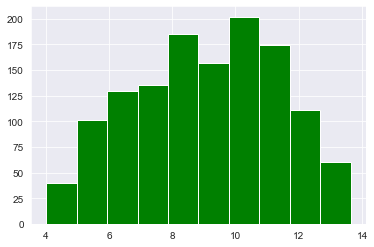

In [30]:
plt.hist(itausa['last'],bins = 10, facecolor = 'green',label='Dist Last')

### Correlation

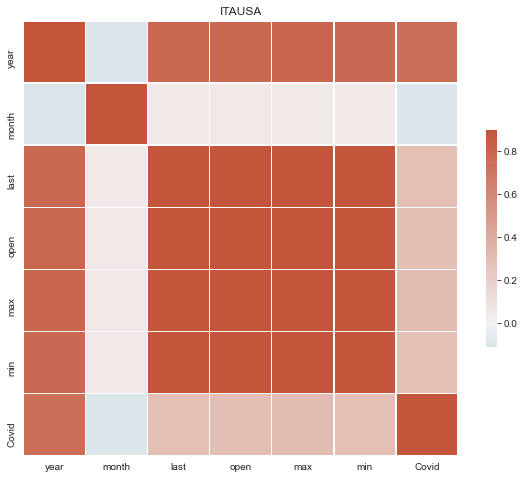

In [20]:
itausa_corr = itausa.corr()

print_corr(itausa_corr,"ITAUSA")

### Stationary Test

In [29]:
adf = adf_test(itausa['last'].diff().dropna())

Augmented Dickey-Fuller Test
test statistic: -12.9157560026
p-value: 0.0000000000
critical values
	1%: -3.4354412127
	5%: -2.8637883403
	10%: -2.5679670339
Rejeitamos a Hipotese Nula


### Observe volatility clustering

Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.

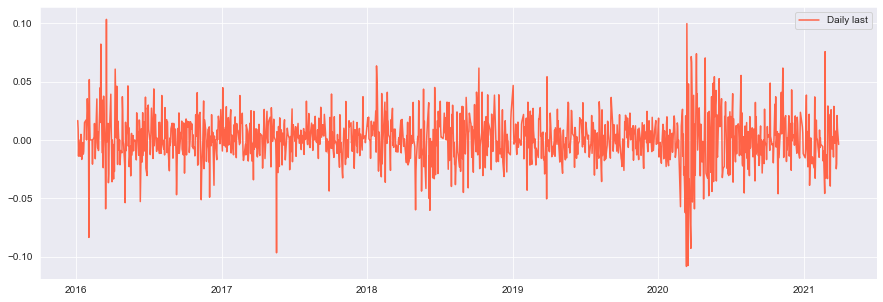

In [32]:
itausa['return_data'] = itausa['last'].pct_change()
itausa['volatility'] = itausa['return_data'].std()

f, axes = plt.subplots(1, figsize=(15,5))
plt.plot(itausa['return_data'], color = 'tomato', label = 'Daily last')
plt.legend(loc='upper right')
plt.show()

In [41]:
std_daily = itausa['return_data'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

Daily volatility:  0.02%


### Multicollinearity

In [34]:
target = 'last'
exog = ['year', 'month', 'open', 'max', 'min', 'Covid','return_data', 'volatility']

vif = varianceInflationFactor_test(itausa,target, exog)
vif

year+month+open+max+min+Covid+return_data+volatility


,VIF Factor,features
0,0.000000,last
1,13.821679,year
2,1.110012,month
3,1201.227783,open
4,841.171193,max
5,721.334169,min
6,5.263909,Covid
7,1.748127,return_data
8,0.000000,volatility


## Arch Modeling

Iteration:      5,   Func. Count:    167,   Neg. LLF: 3558.2255950758477
Iteration:     10,   Func. Count:    334,   Neg. LLF: 3550.719827065284
Iteration:     15,   Func. Count:    499,   Neg. LLF: 3546.883408638573
Iteration:     20,   Func. Count:    666,   Neg. LLF: 3545.0854321215525
Iteration:     25,   Func. Count:    832,   Neg. LLF: 3544.9361686437483
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3544.9361687985856
            Iterations: 26
            Function evaluations: 875
            Gradient evaluations: 26


 Model 
                           Zero Mean - GARCH Model Results                           
Dep. Variable:                         last   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -3544.94
Distribution:      Standardized Student's t   AIC:                         

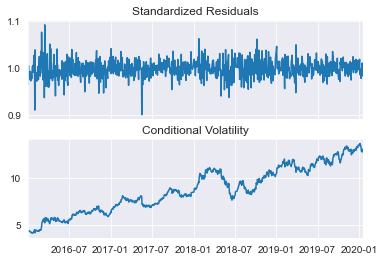

In [182]:
p = 15
q = 15
mean = 'Zero' #'zero', 'AR', 'constant'
type_model = 'GARCH' #'GARCH','ARCH', 'EGARCH'
dist = 't' #'t','skewt','normal'


model_fit, model = get_arch_model(itausa_train['last'],p, q, mean,type_model,dist)

The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level, the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

Besides p-values, t-statistics can also help decide the necessity of model parameters. 

The t-statistic is computed as the estimated parameter value subtracted by its expected mean, and divided by its standard error. The absolute value of the t-statistic is a distance measure, that tells you how many standard errors the estimated parameter is away from 0. As a rule of thumb, if the t-statistic is larger than 2, you can reject the null hypothesis.

In [183]:
para_summary = pd.DataFrame({'parameter':model_fit.params,
                             'p-value': model_fit.pvalues,
                             't-value': model_fit.tvalues,
                             'Log-likelihood': model_fit.loglikelihood,
                             'AIC':model_fit.aic,
                             'BIC':model_fit.bic})
para_summary

,parameter,p-value,t-value,Log-likelihood,AIC,BIC
omega,3.769183e-01,3.259521e-02,2.137034e+00,-3544.936169,7153.872338,7310.920507
alpha[1],9.588714e-01,2.921937e-29,1.122948e+01,-3544.936169,7153.872338,7310.920507
alpha[2],9.713231e-22,1.000000e+00,1.010035e-21,-3544.936169,7153.872338,7310.920507
alpha[3],5.629844e-16,1.000000e+00,7.853002e-16,-3544.936169,7153.872338,7310.920507
alpha[4],0.000000e+00,1.000000e+00,0.000000e+00,-3544.936169,7153.872338,7310.920507
alpha[5],1.837296e-21,1.000000e+00,2.888969e-21,-3544.936169,7153.872338,7310.920507
alpha[6],2.868588e-15,1.000000e+00,1.034636e-14,-3544.936169,7153.872338,7310.920507
alpha[7],3.825871e-15,1.000000e+00,1.105068e-14,-3544.936169,7153.872338,7310.920507
alpha[8],2.364064e-15,1.000000e+00,5.848328e-15,-3544.936169,7153.872338,7310.920507
alpha[9],2.738523e-15,1.000000e+00,2.809614e-15,-3544.936169,7153.872338,7310.920507


### Residual

In [184]:
itausa_resid = model_fit.resid
itausa_std = model_fit.conditional_volatility

itausa_std_resid = itausa_resid/itausa_std

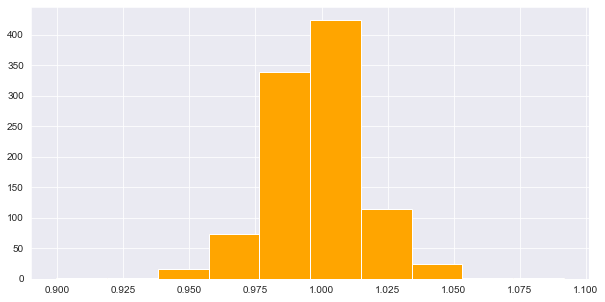

In [185]:
# Plot the histogram of the standardized residuals
f, axes = plt.subplots(1, figsize=(10,5))
plt.hist(itausa_std_resid, facecolor = 'orange', label = 'Standardized residuals')
plt.show()

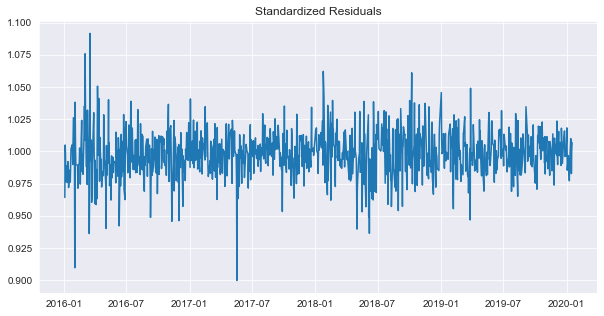

In [186]:
f, axes = plt.subplots(1, figsize=(10,5))
plt.plot(itausa_std_resid)
plt.title('Standardized Residuals')
plt.show()

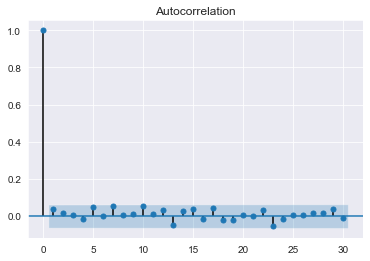

In [187]:
# Generate ACF plot of the standardized residuals
plot_acf(itausa_std_resid, alpha = 0.05)
plt.show()

Another powerful tool to check autocorrelations in the data is the Ljung-Box test.

The null hypothesis of Ljung-Box test is: 

* The data is independently distributed. If the p-value is larger than the specified significance level, the null hypothesis cannot be rejected. 
* In other words, there is no clear sign of autocorrelations and the model is valid.

In [188]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(itausa_std_resid , lags = 10)

# Print the p-values
print('P-values are: ', lb_test[1])

P-values are:  [0.20186577 0.37554682 0.56750381 0.69244827 0.48480199 0.61415357
 0.38015647 0.4841322  0.57392566 0.38984434]


In [189]:
residual = model_fit.resid
normal_distribution_test(residual)
#heteroscedasticity_test(model_fit)


 normal_distribution_test 
 
p value of Jarque-Bera test is:  4.0637937459564455e-11
p value of Shapiro-Wilk test is:  4.5523399503158424e-14
p value of Kolmogorov-Smirnov test is:  0.0


### Rolling window forecast

**Expanding window forecast**

There are mainly two ways to perform a rolling window forecast. One is "expanding window" approach, which starts with a set of sample data, and as time moves forward, continuously adds new data points to the sample. 

Suppose we have 200 observations of a time-series. 

First, we estimate the model with the first 100 observations to forecast the data point 101. Then we include observation 101 into the sample, and estimate the model again to forecast the data point 102. 

The process is repeated until we have forecast for all 100 out-of-sample data points.


Rolling window forecast is widely used because of the following motivations: 

* First, when we use all the data to fit a model, the model estimation has lookback bias. In reality, we do not know the future, so the time series data used for model fitting and forecast should not overlap. 

* Second, the rolling window approach is less subject to overfitting. An implicit time series modeling assumption is model parameters are stable over time. But this barely holds true in turbulent market environment. Imagine when we try to fit a GARCH(1,1) with observations from economic crisis versus normal market conditions, we are likely to obtain very different omega, alpha, beta results. 

* Third, the rolling window approach can better adapt our forecast to changes. By continuously incorporating new observations to the model fitting and forecast, we are more responsive to the most recent economic conditions, such as news, changes in economic cycles, etc.

**Fixed rolling window forecast**

Another rolling window forecast method is call "fixed rolling window forecast". Similarly it starts with a set of sample data, and as time moves forward, new data points are added. What different is old data points are dropped from the sample simultaneously to maintain a fixed window size.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3148.836576286634
            Iterations: 26
            Function evaluations: 876
            Gradient evaluations: 26


 values - > [167.20838677]
Iteration:     30,   Func. Count: 1.01e+03,   Neg. LLF: 3152.683666785379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3152.683664096412
            Iterations: 31
            Function evaluations: 1041
            Gradient evaluations: 31


 values - > [167.20424749]
Iteration:     30,   Func. Count: 1.00e+03,   Neg. LLF: 3156.5230702330664
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3156.522994977131
            Iterations: 40
            Function evaluations: 1338
            Gradient evaluations: 40


 values - > [167.20429454]
Iteration:     30,   Func. Count: 1.01e+03,   Neg. LLF: 3160.378243552562
Optimization terminated successfully    (Exit mode 0)
    

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3266.8353480848773
            Iterations: 27
            Function evaluations: 917
            Gradient evaluations: 27


 values - > [167.3289828]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3270.146115210834
            Iterations: 26
            Function evaluations: 885
            Gradient evaluations: 26


 values - > [167.19672416]
Iteration:     30,   Func. Count:    997,   Neg. LLF: 3274.99409434645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3274.014071576388
            Iterations: 44
            Function evaluations: 1474
            Gradient evaluations: 44


 values - > [167.2056429]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3277.8815069006178
            Iterations: 27
            Function evaluations: 909
            Gradient evaluations: 27



Optimization terminated successfully    (Exit mode 0)
            Current function value: 3389.862299004073
            Iterations: 28
            Function evaluations: 938
            Gradient evaluations: 28


 values - > [167.37030718]
Iteration:     30,   Func. Count: 1.02e+03,   Neg. LLF: 3393.9926316082287
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3393.9912987112352
            Iterations: 50
            Function evaluations: 1694
            Gradient evaluations: 50


 values - > [167.39453446]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3397.015142065691
            Iterations: 21
            Function evaluations: 708
            Gradient evaluations: 21


 values - > [166.92639511]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3400.962477561242
            Iterations: 26
            Function evaluations: 874
            Gradient evaluations:

Iteration:     30,   Func. Count: 1.01e+03,   Neg. LLF: 3516.596739858298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3516.5965206743713
            Iterations: 36
            Function evaluations: 1219
            Gradient evaluations: 36


 values - > [167.23425254]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3521.511327742888
            Iterations: 27
            Function evaluations: 905
            Gradient evaluations: 27


 values - > [167.57490955]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3524.504929862601
            Iterations: 23
            Function evaluations: 783
            Gradient evaluations: 23


 values - > [167.17922251]
Iteration:     30,   Func. Count:  1e+03,   Neg. LLF: 3529.3107329699633
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3529.3106424748025
            Iterations: 3

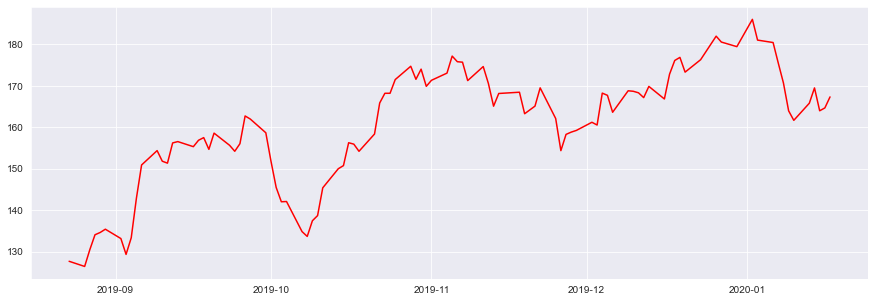

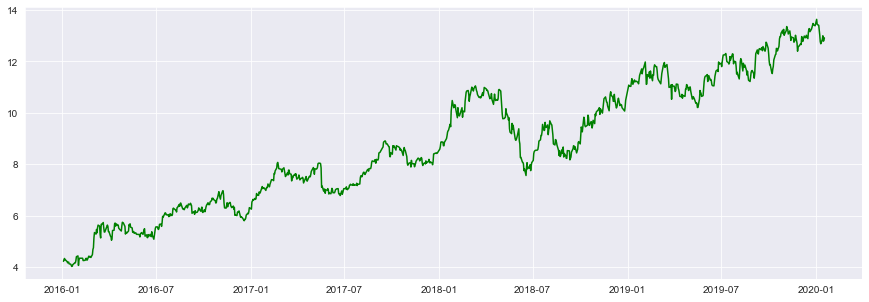

In [191]:
start_loc = 0
end_loc = 900
window = 100

forecast_exprw = expanding_rw_forecast(model,itausa_train['last'],start_loc,end_loc,window)

Iteration:     15,   Func. Count:     80,   Neg. LLF: 71757.41076295651
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1548.1619819659613
            Iterations: 24
            Function evaluations: 111
            Gradient evaluations: 22
Iteration:     15,   Func. Count:     81,   Neg. LLF: 3131.9065647941316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1556.4194017153045
            Iterations: 26
            Function evaluations: 116
            Gradient evaluations: 22
Iteration:     15,   Func. Count:     79,   Neg. LLF: 1547.9857809561067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1547.8357091059447
            Iterations: 20
            Function evaluations: 95
            Gradient evaluations: 19
Iteration:     15,   Func. Count:     79,   Neg. LLF: 1547.7422312405604
Optimization terminated successfully    (Exit mode 0)
            Current fun

Iteration:     15,   Func. Count:     78,   Neg. LLF: 1726.7247736158815
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1549.9326723041872
            Iterations: 25
            Function evaluations: 115
            Gradient evaluations: 23
Iteration:     15,   Func. Count:     79,   Neg. LLF: 3399.7829020549298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1567.7480803382186
            Iterations: 27
            Function evaluations: 121
            Gradient evaluations: 23
Iteration:     15,   Func. Count:     79,   Neg. LLF: 3220.653734831191
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1549.8249689480765
            Iterations: 22
            Function evaluations: 100
            Gradient evaluations: 20
Iteration:     15,   Func. Count:     78,   Neg. LLF: 1549.8353061263458
Optimization terminated successfully    (Exit mode 0)
            Current fu

Iteration:     15,   Func. Count:     77,   Neg. LLF: 1564.8889728056997
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1564.8889707534427
            Iterations: 18
            Function evaluations: 84
            Gradient evaluations: 17
Iteration:     15,   Func. Count:     78,   Neg. LLF: 1565.3799222327461
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1565.3797030941969
            Iterations: 18
            Function evaluations: 86
            Gradient evaluations: 17
Iteration:     15,   Func. Count:     80,   Neg. LLF: 1566.050487207398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1565.8805258424327
            Iterations: 21
            Function evaluations: 99
            Gradient evaluations: 20
Iteration:     15,   Func. Count:     79,   Neg. LLF: 1566.3599229683023
Optimization terminated successfully    (Exit mode 0)
            Current funct

Iteration:     15,   Func. Count:     77,   Neg. LLF: 1583.960380687158
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1583.9562835538004
            Iterations: 20
            Function evaluations: 93
            Gradient evaluations: 19
Iteration:     15,   Func. Count:     80,   Neg. LLF: 1584.6664783598171
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1584.596731199605
            Iterations: 22
            Function evaluations: 104
            Gradient evaluations: 21
Iteration:     15,   Func. Count:     77,   Neg. LLF: 1585.2059134328513
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1585.2027142367745
            Iterations: 19
            Function evaluations: 88
            Gradient evaluations: 18
Iteration:     15,   Func. Count:     78,   Neg. LLF: 1585.868512335912
Optimization terminated successfully    (Exit mode 0)
            Current functi

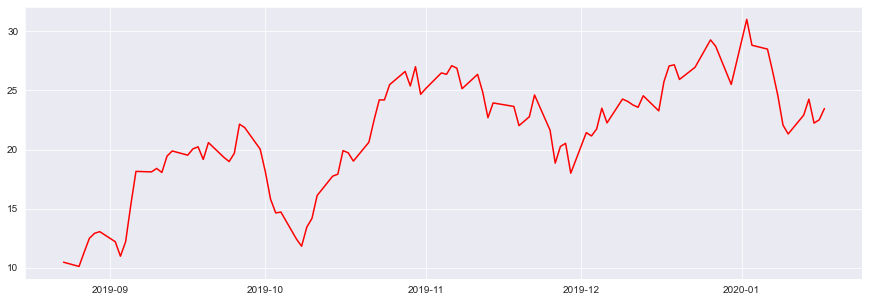

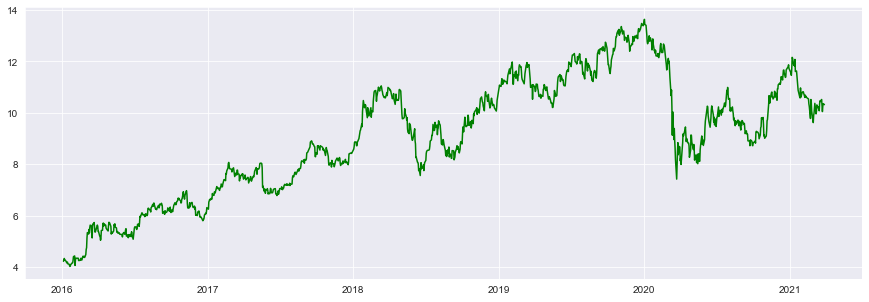

In [113]:
forecast_fixrw = fixed_rw_forecast(model,itausa['last'],start_loc,end_loc,window)

In [ ]:
# In[] Goodness of fit measures